In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read the csv file
userlog = pd.read_csv('user_logs.csv')
# Set datetime object as the index
userlog = userlog.set_index(userlog.datetime)
# Drop the original datetime column
userlog.drop(columns='datetime',inplace=True)

In [3]:
# Set 'datetime' as a datetime index.
userlog.index = pd.to_datetime(userlog.index)

In [4]:
# Verify index was set.
userlog.index

DatetimeIndex(['2018-01-26 09:55:03', '2018-01-26 09:56:02',
               '2018-01-26 09:56:05', '2018-01-26 09:56:06',
               '2018-01-26 09:56:24', '2018-01-26 09:56:41',
               '2018-01-26 09:56:46', '2018-01-26 09:56:48',
               '2018-01-26 09:56:59', '2018-01-26 09:58:26',
               ...
               '2021-04-21 16:38:14', '2021-04-21 16:41:29',
               '2021-04-21 16:41:31', '2021-04-21 16:41:49',
               '2021-04-21 16:41:51', '2021-04-21 16:41:51',
               '2021-04-21 16:42:02', '2021-04-21 16:42:09',
               '2021-04-21 16:44:37', '2021-04-21 16:44:39'],
              dtype='datetime64[ns]', name='datetime', length=847330, freq=None)

In [5]:
len(userlog.cohort_name.value_counts())

47

In [6]:
len(userlog.slack.value_counts())

46

In [7]:
userlog.cohort_name.value_counts()

Staff         84031
Ceres         40730
Zion          38096
Jupiter       37109
Fortuna       36902
Voyageurs     35636
Ganymede      33844
Apex          33568
Deimos        32888
Darden        32015
Teddy         30926
Hyperion      29855
Betelgeuse    29356
Ulysses       28534
Europa        28033
Xanadu        27749
Bayes         26538
Wrangell      25586
Andromeda     25359
Kalypso       23691
Curie         21582
Yosemite      20743
Bash          17713
Luna          16623
Marco         16397
Easley        14715
Lassen         9587
Arches         8890
Florence       8562
Sequoia        7444
Neptune        7276
Olympic        4954
Kings          2845
Pinnacles      2158
Hampton        1712
Oberon         1672
Quincy         1237
Niagara         755
Mammoth         691
Glacier         598
Joshua          302
Ike             253
Badlands         93
Franklin         72
Apollo            5
Denali            4
Everglades        1
Name: cohort_name, dtype: int64

In [8]:
userlog.slack.value_counts()

#              110569
#ceres          40730
#zion           38096
#jupiter        37109
#fortuna        36902
#voyageurs      35636
#ganymede       33844
#apex           33568
#deimos         32888
#darden         32015
#teddy          30926
#hyperion       29855
#betelgeuse     29356
#ulysses        28534
#europa         28033
#xanadu         27749
#wrangell       25586
#andromeda      25359
#kalypso        23691
#curie          21582
#yosemite       20743
#bash           17713
#luna           16623
#marco          16397
#easley         14715
#lassen          9587
#arches          8890
#florence        8562
#sequoia         7444
#neptune         7276
#olympic         4954
#kings           2845
#pinnacles       2158
#hampton         1712
#oberon          1672
#quincy          1237
#niagara          755
#mammoth          691
#glacier          598
#joshua           302
#ike              253
#badlands          93
#franklin          72
#apollo             5
#denali             4
#everglade

# Takeaways
* Bayes is missing a slack channel
* They may have been put in the '#' slack channel.
* **update** The Bayes cohort was put into the '#' slack channel.

In [9]:
# Convert all datetime values into datetime datatype
userlog.end_date = pd.to_datetime(userlog.end_date)
userlog.start_date = pd.to_datetime(userlog.start_date)
userlog.created_at = pd.to_datetime(userlog.created_at)
userlog.updated_at = pd.to_datetime(userlog.updated_at)

In [10]:
# Drop 'deleted_at' column
userlog.drop(columns='deleted_at', inplace=True)

In [11]:
userlog.path.value_counts()

/                                          45854
javascript-i                               18203
toc                                        17591
search/search_index.json                   17534
java-iii                                   13166
                                           ...  
content/mysql/intro-to-mysql/index.html        1
11-distributed-ml/3-getting-started            1
java-iii/mvc.jsp                               1
12-distributed-ml/6.1-prepare-part-1           1
teams                                          1
Name: path, Length: 2224, dtype: int64

# Takeaways
* 2224 different paths were accessed.

In [12]:
userlog.path.apply(type).value_counts()

<class 'str'>      847329
<class 'float'>         1
Name: path, dtype: int64

# Takeaways
* There is one observtion that is a float datatype that is screwing everything up.

In [13]:
# Drop nan values(there is only one)
userlog.dropna(inplace=True)

In [14]:
# Split the 'path' column at the backslash
userlog['path_split'] = userlog.path.str.split('/')

In [15]:
# Create a new column for module name and lesson
userlog['module'] = [mod[0] for mod in userlog.path_split]
# Create a second item for the lists that only have one time
for mod in userlog.path_split:    
    if len(mod) == 1:
        mod = mod.append('')

userlog['lesson'] = [mod[1] for mod in userlog.path_split]

# Takeaways
* The dataframe is wrangled and now ready for exploration.

In [16]:
userlog.index.min(), userlog.index.max()

(Timestamp('2018-01-26 09:55:03'), Timestamp('2021-04-21 16:44:39'))

In [17]:
userlog.program_id.value_counts()

2    713365
3    103411
1     30548
4         5
Name: program_id, dtype: int64

In [18]:
userlog[userlog.program_id == 4].lesson.value_counts().head(50)

html-css    4
            1
Name: lesson, dtype: int64

In [19]:
userlog['program'] = userlog.program_id.map(
    {
        1.0: 'Full-Stack PHP',
        2.0: 'Full-Stack Java',
        3.0: 'Data Science',
        4.0: 'Front-End'
    })

In [20]:
userlog[userlog.program_id == 3]

,cohort_id,cohort_name,slack,start_date,end_date,created_at,updated_at,program_id,path,user_id,ip,path_split,module,lesson,program
datetime,,,,,,,,,,,,,,,
2019-08-20 09:39:58,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,/,466,97.105.19.58,"[, ]",,,Data Science
2019-08-20 09:39:59,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,/,467,97.105.19.58,"[, ]",,,Data Science
2019-08-20 09:39:59,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,/,468,97.105.19.58,"[, ]",,,Data Science
2019-08-20 09:40:02,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,/,469,97.105.19.58,"[, ]",,,Data Science
2019-08-20 09:40:08,34,Bayes,#,2019-08-19,2020-01-30,2019-08-20 14:38:55,2019-08-20 14:38:55,3,/,470,97.105.19.58,"[, ]",,,Data Science
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:14:16,133,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,3,regression/project,841,99.162.244.233,"[regression, project]",regression,project,Data Science
2021-04-21 16:15:51,133,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,3,regression/project,841,99.162.244.233,"[regression, project]",regression,project,Data Science
2021-04-21 16:23:53,133,Easley,#easley,2020-12-07,2021-06-08,2020-12-07 15:20:18,2020-12-07 15:20:18,3,/,143,173.174.194.60,"[, ]",,,Data Science


### At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?


In [21]:
pd.set_option('display.max_rows', 3000)

In [22]:
userlog['ds_student'] = userlog.program_id == 3

In [23]:
# Print out a list of the unique paths visited by Web Development students.
list(userlog[userlog.ds_student == False].path.unique())

['/',
 'java-ii',
 'java-ii/object-oriented-programming',
 'slides/object_oriented_programming',
 'javascript-i/conditionals',
 'javascript-i/loops',
 'javascript-i/functions',
 'mkdocs/search_index.json',
 'javascript-i/introduction/working-with-data-types-operators-and-variables',
 'javascript-i',
 'javascript-i/introduction/variables',
 'javascript-i/introduction/operators',
 'git/merge-conflict-demo',
 'git/working-in-teams',
 'javascript-i/introduction/primitive-types',
 'javascript-i/javascript-with-html',
 'spring',
 'appendix',
 'spring/extra-features/file-upload',
 'appendix/capstone-workbook',
 'javascript-i/objects/math',
 'index.html',
 'java-i',
 'appendix/further-reading/javascript/hoisting.html',
 'html-css/introduction',
 'javascript-i/bom-and-dom',
 'javascript-i/bom-and-dom/bom',
 'examples/javascript/defuse-the-bom.html',
 'javascript-i/introduction',
 'javascript-i/bom-and-dom/dom',
 'examples/javascript/dom-query-js.html',
 'spring/fundamentals/security/authenticat

In [24]:
# Show list of unique paths visited by Data Science students.
list(userlog[userlog.ds_student == True].path.unique())

['/',
 '3-sql/1-mysql-overview',
 '2-storytelling/bad-charts',
 '2-storytelling/misleading1_baseball.jpg',
 '2-storytelling/misleading1_fox.jpg',
 '2-storytelling/misleading3_deaths.jpg',
 'appendix/cli-git-overview',
 '1-fundamentals/1.1-intro-to-data-science',
 '1-fundamentals/modern-data-scientist.jpg',
 '1-fundamentals/AI-ML-DL-timeline.jpg',
 '1-fundamentals/1.2-data-science-pipeline',
 '1-fundamentals/DataToAction_v2.jpg',
 'search/search_index.json',
 '13-advanced-topics/3.7-styling-webpages',
 '1-fundamentals/1.3-pipeline-demo',
 '1-fundamentals/2.1-excel-overview',
 '3-vocabulary.md',
 '6-regression/1-overview',
 '10-anomaly-detection/1-overview',
 '10-anomaly-detection/AnomalyDetectionCartoon.jpeg',
 '11-nlp/1-overview',
 '6-regression/2-regression-excel',
 '6-regression/3.1-acquire-and-prep',
 '6-regression/3.2-split-and-scale',
 '6-regression/3.3-explore',
 '6-regression/3.4-feature-engineering',
 '6-regression/3.5-modeling',
 '6-regression/3.6-evaluation',
 '6-regression/e

In [25]:
# Save list for Data Science students.
datascience = list(userlog[userlog.ds_student == True].module.unique())

In [26]:
# Save list for Web Development students.
webdev = list(userlog[userlog.ds_student == False].module.unique())

In [27]:
len(datascience), len(webdev)

(153, 610)

In [28]:
# Conver lists into sets.
set_datascience = set(datascience)
set_webdev = set(webdev)

In [29]:
# Create a set that contains the paths that both Web Development students and Data Science students
# are accessing.
set1 = set_webdev.intersection(set_datascience)

In [30]:
set_datascience

{'',
 '%20https:',
 ',%20https:',
 '.gitignore',
 '1-fundamentals',
 '1-overview',
 '1.2-data-science-pipeline',
 '1.3-pipeline-demo',
 '10-anomaly-detection',
 '11-nlp',
 '12-distributed-ml',
 '13-advanced-topics',
 '13.1_Understand',
 '2-storytelling',
 '2.1-spreadsheets-overview',
 '3-acquire',
 '3-data-types-and-variables',
 '3-databases',
 '3-discrete-probabilistic-methods',
 '3-probability-distributions',
 '3-sql',
 '3-vocabulary',
 '3-vocabulary.md',
 '4-detecting-timeseries-anomalies',
 '4-python',
 '4.2-compare-means',
 '4.5-more-statistical-testing-examples',
 '5-detecting-with-clustering',
 '5-stats',
 '6-regression',
 '7-classification',
 '7.4.1-pandas-overview',
 '7.4.2-series',
 '8-clustering',
 '9-timeseries',
 'A-clustering',
 'AI-ML-DL-timeline.jpg',
 'AnomalyDetectionCartoon.jpeg',
 'DataToAction_v2.jpg',
 'End_to_End_clustering',
 'Hospital-Distance-Clusters.jpg',
 'Index.html',
 'Pipeline_Demo',
 'Selecting_a_hypothesis_test.svg',
 'acquire',
 'acquire-and-prep',
 '

In [31]:
# Check the amount of visits to the '6-regression' path for Data Science students.
(userlog[userlog.ds_student == True].module == '6-regression').sum()

4562

In [32]:
# Check the amount of visits to the '6-regression' path for Web Development students.
(userlog[userlog.ds_student == False].module == '6-regression').sum()

1283

In [33]:
set1

{'',
 '.gitignore',
 '1-fundamentals',
 '10-anomaly-detection',
 '11-nlp',
 '12-distributed-ml',
 '13-advanced-topics',
 '13.1_Understand',
 '2-storytelling',
 '3-sql',
 '3-vocabulary.md',
 '4-python',
 '5-stats',
 '6-regression',
 '7-classification',
 '8-clustering',
 '9-timeseries',
 'AI-ML-DL-timeline.jpg',
 'AnomalyDetectionCartoon.jpeg',
 'Hospital-Distance-Clusters.jpg',
 'Pipeline_Demo',
 'acquire',
 'advanced-topics',
 'alumni',
 'anomaly-detection',
 'appendix',
 'basic-statements',
 'capstones',
 'classification',
 'clustering',
 'create',
 'curie-python-assessment',
 'darden-python-assessment.html',
 'database-design',
 'databases',
 'dataframes',
 'distributed-ml',
 'examples',
 'explore',
 'florence-python-assessment.html',
 'functions',
 'fundamentals',
 'git',
 'grades',
 'group-by',
 'html-css',
 'index.html',
 'individual-project',
 'java-i',
 'java-ii',
 'java-iii',
 'javascript-i',
 'javascript-ii',
 'jquery',
 'login',
 'misleading1_baseball.jpg',
 'misleading1_fox.

### Create a for loop that will compare the amount of visits to a certain path. Append the path to the correct list.

In [34]:
ds_path = []
webdev_path = []
for path in set1:
    if (userlog[userlog.ds_student == True].module == path).sum() > (userlog[userlog.ds_student == False].module == path).sum():
        ds_path.append(path)
    else:
        webdev_path.append(path)

In [35]:
# Verify length of set1.
len(set1)

76

In [36]:
len(ds_path), len(webdev_path)

(42, 34)

## Based on domain knowledge, verify if paths belong to Data Science curriculum.

In [37]:
ds_path

['9-timeseries',
 'acquire',
 '12-distributed-ml',
 'dataframes',
 'individual-project',
 '4-python',
 '7-classification',
 'florence-python-assessment.html',
 '5-stats',
 '10-anomaly-detection',
 'darden-python-assessment.html',
 'advanced-topics',
 'pandas-overview',
 '1-fundamentals',
 'stats',
 '3-sql',
 '8-clustering',
 'python',
 '11-nlp',
 'modern-data-scientist.jpg',
 'nlp',
 'user-defined-functions.md',
 'anomaly-detection',
 'fundamentals',
 'overview',
 '13-advanced-topics',
 'timeseries',
 'series',
 'explore',
 '6-regression',
 'working-with-time-series-data',
 'sql',
 'clustering',
 'create',
 'distributed-ml',
 'capstones',
 'storytelling',
 'AI-ML-DL-timeline.jpg',
 '2-storytelling',
 'curie-python-assessment',
 'regression',
 'classification']

# Takeaways
* Everything seems to check out for me. I will need a Data Science curriculum expert to verify.

In [38]:
userlog

,cohort_id,cohort_name,slack,start_date,end_date,created_at,updated_at,program_id,path,user_id,ip,path_split,module,lesson,program,ds_student
datetime,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,/,1,97.105.19.61,"[, ]",,,Full-Stack PHP,False
2018-01-26 09:56:02,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,java-ii,1,97.105.19.61,"[java-ii, ]",java-ii,,Full-Stack PHP,False
2018-01-26 09:56:05,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,java-ii/object-oriented-programming,1,97.105.19.61,"[java-ii, object-oriented-programming]",java-ii,object-oriented-programming,Full-Stack PHP,False
2018-01-26 09:56:06,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,slides/object_oriented_programming,1,97.105.19.61,"[slides, object_oriented_programming]",slides,object_oriented_programming,Full-Stack PHP,False
2018-01-26 09:56:24,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,javascript-i/conditionals,2,97.105.19.61,"[javascript-i, conditionals]",javascript-i,conditionals,Full-Stack Java,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/personal-site,64,71.150.217.33,"[jquery, personal-site]",jquery,personal-site,Full-Stack Java,False
2021-04-21 16:42:02,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/mapbox-api,64,71.150.217.33,"[jquery, mapbox-api]",jquery,mapbox-api,Full-Stack Java,False
2021-04-21 16:42:09,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/ajax/weather-map,64,71.150.217.33,"[jquery, ajax, weather-map]",jquery,ajax,Full-Stack Java,False


## Based on domain knowledge, verify if paths belong to Web Development curriculum.

In [39]:
webdev_path

['',
 'misleading1_fox.jpg',
 'login',
 'javascript-i',
 'mkdocs',
 'spring',
 'toc',
 'group-by',
 'mysql',
 'java-ii',
 'index.html',
 'basic-statements',
 'misleading1_baseball.jpg',
 'grades',
 '13.1_Understand',
 'jquery',
 'git',
 'functions',
 'AnomalyDetectionCartoon.jpeg',
 'alumni',
 '.gitignore',
 'database-design',
 'javascript-ii',
 'Hospital-Distance-Clusters.jpg',
 '3-vocabulary.md',
 'java-i',
 'search',
 'misleading3_deaths.jpg',
 'java-iii',
 'databases',
 'examples',
 'appendix',
 'html-css',
 'Pipeline_Demo']

# Takeaways
* There are a couple of items that may be from the Data Science curriculum, but they are just images.

In [40]:
# Convert newly created list into a set.
ds_path = set(ds_path)

In [41]:
# Convert newly created list into a set.
webdev_path = set(webdev_path)

In [42]:
# Check lengths to use for verification later.
len(set_datascience), len(webdev_path), len(set_datascience)-len(webdev_path)

(153, 34, 119)

In [43]:
# Create a new set for Data Science paths only.
datascience_paths = set_datascience.difference(webdev_path)

In [44]:
# Create a new set for Web Development paths only.
webdev_paths = set_webdev.difference(ds_path)

In [45]:
userlog[userlog.ds_student == True].module == datascience_paths

datetime
2019-08-20 09:39:58    False
2019-08-20 09:39:59    False
2019-08-20 09:39:59    False
2019-08-20 09:40:02    False
2019-08-20 09:40:08    False
                       ...  
2021-04-21 16:14:16    False
2021-04-21 16:15:51    False
2021-04-21 16:23:53    False
2021-04-21 16:23:57    False
2021-04-21 16:32:50    False
Name: module, Length: 103411, dtype: bool

In [46]:
data_science_hits = userlog[userlog.module.isin(datascience_paths)]

In [47]:
webdev_hits = userlog[userlog.module.isin(webdev_paths)]

In [48]:
len(data_science_hits), len(webdev_hits), len(data_science_hits)+len(webdev_hits)

(110980, 736349, 847329)

In [49]:
# Create a dataframe of all Data Science curriculum hits that are from Web Development students.
webdev_ds_hits = data_science_hits[data_science_hits.ds_student == False]

In [50]:
webdev_ds_hits.shape[0]

22238

In [51]:
# Create a dataframe of all Web Development curriculum hits that are from Web Development students.
webdev_webdev_hits = webdev_hits[webdev_hits.ds_student == False]

In [52]:
webdev_webdev_hits.shape[0]

721680

## Resample each Web Development dataframe by day and plot activity.

In [92]:
webdev_webdev_hits

,cohort_id,cohort_name,slack,start_date,end_date,created_at,updated_at,program_id,path,user_id,ip,path_split,module,lesson,program,ds_student
datetime,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,/,1,97.105.19.61,"[, ]",,,Full-Stack PHP,False
2018-01-26 09:56:02,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,java-ii,1,97.105.19.61,"[java-ii, ]",java-ii,,Full-Stack PHP,False
2018-01-26 09:56:05,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,java-ii/object-oriented-programming,1,97.105.19.61,"[java-ii, object-oriented-programming]",java-ii,object-oriented-programming,Full-Stack PHP,False
2018-01-26 09:56:06,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,slides/object_oriented_programming,1,97.105.19.61,"[slides, object_oriented_programming]",slides,object_oriented_programming,Full-Stack PHP,False
2018-01-26 09:56:24,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,javascript-i/conditionals,2,97.105.19.61,"[javascript-i, conditionals]",javascript-i,conditionals,Full-Stack Java,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,135,Marco,#marco,2021-01-25,2021-07-19,2021-01-20 21:31:11,2021-01-20 21:31:11,2,javascript-i/bom-and-dom/dom,875,24.242.150.231,"[javascript-i, bom-and-dom, dom]",javascript-i,bom-and-dom,Full-Stack Java,False
2021-04-21 16:41:51,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/personal-site,64,71.150.217.33,"[jquery, personal-site]",jquery,personal-site,Full-Stack Java,False
2021-04-21 16:42:02,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/mapbox-api,64,71.150.217.33,"[jquery, mapbox-api]",jquery,mapbox-api,Full-Stack Java,False


Text(0, 0.5, 'Hits')

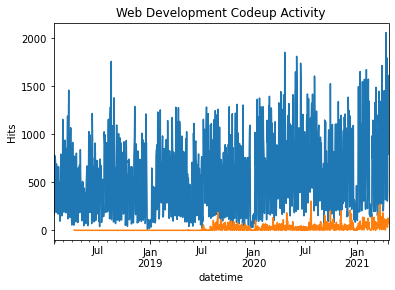

In [53]:
(webdev_webdev_hits.resample('d').path.count()).plot()
(webdev_ds_hits.resample('d').path.count()).plot()
plt.title('Web Development Codeup Activity')
plt.ylabel('Hits')

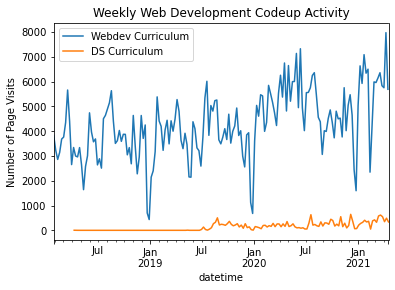

In [116]:
# Resample by week and plot the same data from above.
webdev_webdev_hits.resample('7d').path.count().plot(label='Webdev Curriculum')
webdev_ds_hits.resample('7d').path.count().plot(label='DS Curriculum')
plt.title('Weekly Web Development Codeup Activity')
plt.ylabel('Number of Page Visits')
plt.legend()

In [54]:
# Create a dataframe of all Data Science curriculum hits that are from Data Science students.
ds_ds_hits = data_science_hits[data_science_hits.ds_student == True]

In [55]:
ds_ds_hits.index.min(), ds_ds_hits.index.max()

(Timestamp('2019-08-20 09:40:28'), Timestamp('2021-04-21 16:32:50'))

In [56]:
# Create a dataframe of all Web Development curriculum hits that are from Data Science students.
ds_webdev_hits = webdev_hits[webdev_hits.ds_student == True]

In [57]:
ds_webdev_hits.index.min(), ds_webdev_hits.index.max()

(Timestamp('2019-08-20 09:39:58'), Timestamp('2021-04-21 16:23:53'))

In [58]:
# Verify all added together equals total
webdev_ds_hits.shape[0]+webdev_webdev_hits.shape[0]+ds_ds_hits.shape[0]+ds_webdev_hits.shape[0]

847329

## Resample each Data Science dataframe by day and plot activity.

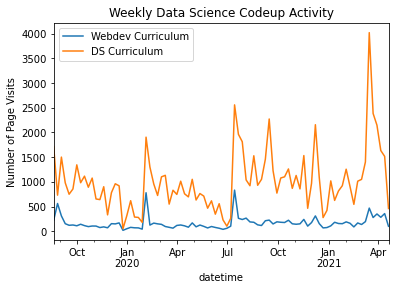

In [115]:
(ds_webdev_hits.resample('7d').path.count()).plot(label='Webdev Curriculum')
(ds_ds_hits.resample('7d').path.count()).plot(label='DS Curriculum')
plt.title('Weekly Data Science Codeup Activity')
plt.ylabel('Number of Page Visits')
plt.legend()

# Takeaways
* According my my graphs it doesn't seem as if the ability to access both curriculums was turned off.
* It seems as if it was turned on for Web Development students sometime in July of 2019.

### Resample the data by day and plot number of page visits/day for Web Development students.

In [60]:
web_dev_page_visits = userlog[userlog.ds_student == False].resample('d').path.count()

<AxesSubplot:xlabel='datetime'>

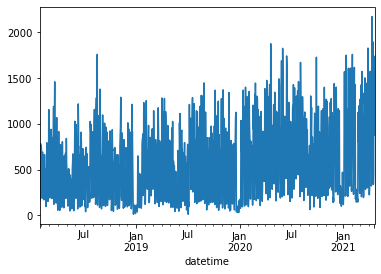

In [61]:
web_dev_page_visits.plot()

## Use Bolinger Bands to set upper and lower limits for normal activity. This method will be used to identify abnormal page visits.

### Set Midband

#### The Exponential Moving Average

In [62]:
# Compute the midband.
midband = web_dev_page_visits.ewm(span=30).mean()

<AxesSubplot:xlabel='datetime'>

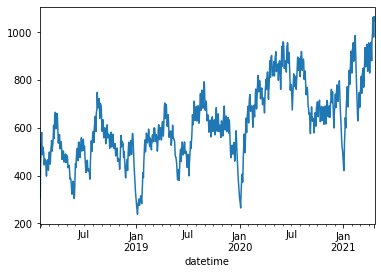

In [63]:
midband.plot()

## Set Upper & Lower Band

UB/LB = Midband +/- stdev * K

In [64]:
# Compute the exponential standard deviation.
stdev = web_dev_page_visits.ewm(span=30).std()

In [65]:
# Compute the upper and lower bands.
ub = midband + stdev*2
lb = midband - stdev*2

In [66]:
# Concatenate upper band and lower band together into one dataframe, bb.
bb = pd.concat([ub, lb], axis=1)
# Set names of columns.
bb.columns = ['ub', 'lb']

# Create a dataframe that holds the values for 'pages', 'midband', and the newly created 'bb'.
my_df = pd.concat([web_dev_page_visits, midband, bb], axis=1)
my_df.columns = ['web_dev_page_visits', 'midband', 'ub', 'lb']
my_df.head()

,web_dev_page_visits,midband,ub,lb
datetime,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,804.956709,-52.056709
2018-01-28,168,302.284709,687.762221,-83.192803
2018-01-29,783,434.739290,1019.718202,-150.239623
2018-01-30,614,475.525441,1001.085795,-50.034912


## Plot number of page visits along with the Bollinger Bands

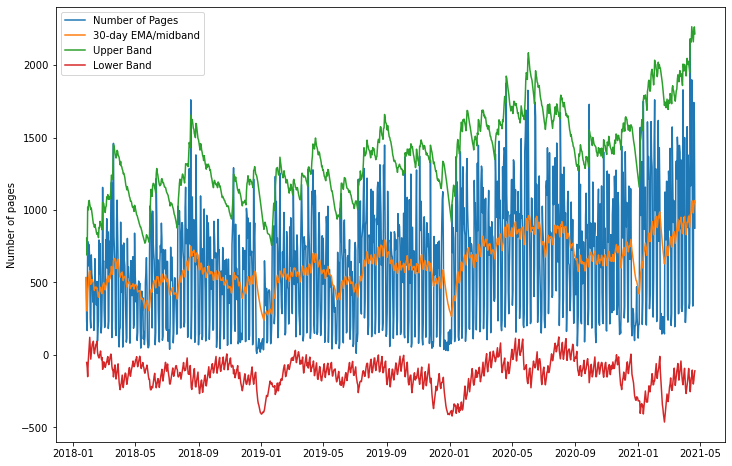

In [67]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.web_dev_page_visits, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [68]:
# A list of the amount of page visits for each cohort
userlog[userlog.ds_student == False].cohort_name.value_counts()

Staff         84031
Ceres         40730
Zion          38096
Jupiter       37109
Fortuna       36902
Voyageurs     35636
Ganymede      33844
Apex          33568
Deimos        32888
Teddy         30926
Hyperion      29855
Betelgeuse    29356
Ulysses       28534
Europa        28033
Xanadu        27749
Wrangell      25586
Andromeda     25359
Kalypso       23691
Yosemite      20743
Bash          17713
Luna          16623
Marco         16397
Lassen         9587
Arches         8890
Sequoia        7444
Neptune        7276
Olympic        4954
Kings          2845
Pinnacles      2158
Hampton        1712
Oberon         1672
Quincy         1237
Niagara         755
Mammoth         691
Glacier         598
Joshua          302
Ike             253
Badlands         93
Franklin         72
Apollo            5
Denali            4
Everglades        1
Name: cohort_name, dtype: int64

### Plot the distribution of page visits for Web Development students.

<AxesSubplot:>

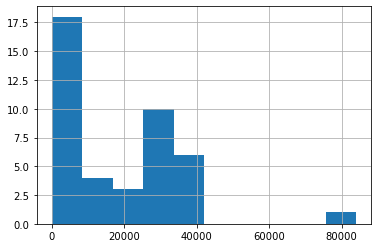

In [69]:
userlog[userlog.ds_student == False].cohort_name.value_counts().hist()

In [70]:
userlog[userlog.ds_student == False].cohort_name.value_counts().mean()

17712.333333333332

### What topics are grads continuing to reference after graduation and into their jobs (for each program)?


In [71]:
userlog.end_date.unique().shape

(45,)

In [72]:
cohort_end = pd.DataFrame(userlog.groupby(['cohort_name']).end_date.max())

In [73]:
cohort_end

,end_date
cohort_name,
Andromeda,2019-07-30
Apex,2020-07-29
Apollo,2015-07-29
Arches,2014-04-22
Badlands,2014-08-22
Bash,2021-01-21
Bayes,2020-01-30
Betelgeuse,2019-10-08
Ceres,2019-12-11


In [74]:
n = 0
cohort_names = list(cohort_end.index)
for end in cohort_end.end_date:
    b = pd.DataFrame(userlog[userlog.index > end])
    print('\n', cohort_names[n])
    print(b[b.cohort_name == cohort_names[n]].path.value_counts().head(5))
    n += 1


 Andromeda
/           404
spring      228
java-iii    180
java-ii     123
mysql       103
Name: path, dtype: int64

 Apex
search/search_index.json    328
/                           253
java-ii                     181
java-i                      180
spring                      153
Name: path, dtype: int64

 Apollo
content/html-css                               2
content/html-css/introduction.html             1
/                                              1
content/html-css/gitbook/images/favicon.ico    1
Name: path, dtype: int64

 Arches
/                626
javascript-i     294
html-css         215
javascript-ii    204
spring           192
Name: path, dtype: int64

 Badlands
/                                              17
content/php_ii/command-line                     6
content/php_i                                   5
content/php_ii/command-line/io-streams.html     5
content/php_ii/control-structures-i             5
Name: path, dtype: int64

 Bash
spring                       

# Takeaways
* Here are the top 5 hits for each cohort after graduating.

In [75]:
ds_cohort_set = set(userlog[userlog.ds_student == True].cohort_name.unique())

In [76]:
ds_cohort_set

{'Bayes', 'Curie', 'Darden', 'Easley', 'Florence'}

### Which lessons are least accessed?

In [77]:
userlog

,cohort_id,cohort_name,slack,start_date,end_date,created_at,updated_at,program_id,path,user_id,ip,path_split,module,lesson,program,ds_student
datetime,,,,,,,,,,,,,,,,
2018-01-26 09:55:03,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,/,1,97.105.19.61,"[, ]",,,Full-Stack PHP,False
2018-01-26 09:56:02,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,java-ii,1,97.105.19.61,"[java-ii, ]",java-ii,,Full-Stack PHP,False
2018-01-26 09:56:05,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,java-ii/object-oriented-programming,1,97.105.19.61,"[java-ii, object-oriented-programming]",java-ii,object-oriented-programming,Full-Stack PHP,False
2018-01-26 09:56:06,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,slides/object_oriented_programming,1,97.105.19.61,"[slides, object_oriented_programming]",slides,object_oriented_programming,Full-Stack PHP,False
2018-01-26 09:56:24,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,javascript-i/conditionals,2,97.105.19.61,"[javascript-i, conditionals]",javascript-i,conditionals,Full-Stack Java,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/personal-site,64,71.150.217.33,"[jquery, personal-site]",jquery,personal-site,Full-Stack Java,False
2021-04-21 16:42:02,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/mapbox-api,64,71.150.217.33,"[jquery, mapbox-api]",jquery,mapbox-api,Full-Stack Java,False
2021-04-21 16:42:09,28,Staff,#,2014-02-04,2014-02-04,2018-12-06 17:04:19,2018-12-06 17:04:19,2,jquery/ajax/weather-map,64,71.150.217.33,"[jquery, ajax, weather-map]",jquery,ajax,Full-Stack Java,False


In [78]:
# Get list of staff members' 'user_id's.
staff_user_id = userlog[userlog.cohort_name == 'Staff'].user_id.unique()

## Find the paths most visited after graduation for Data Science students.

In [79]:
# Create a dataframe where the curriculum hits happen after the student's graduation.
post_graduation_ds = userlog[userlog.index > userlog.end_date]

In [118]:
# Get the value counts for top-ten paths visited.
post_graduation_ds[post_graduation_ds.ds_student == True].path.value_counts().head(10)

/                                                 1446
search/search_index.json                           493
sql/mysql-overview                                 275
classification/overview                            267
classification/scale_features_or_not.svg           220
anomaly-detection/AnomalyDetectionCartoon.jpeg     193
anomaly-detection/overview                         191
fundamentals/AI-ML-DL-timeline.jpg                 189
fundamentals/modern-data-scientist.jpg             187
fundamentals/intro-to-data-science                 184
Name: path, dtype: int64

In [154]:
# Create a dataframe for the top lessons for Data Science graduates.
top_lessons_ds = pd.DataFrame(post_graduation_ds[post_graduation_ds.ds_student == True].path.value_counts().head(10))

In [155]:
# Reset the index and rename it to 'lesson'
top_lessons_ds = top_lessons_ds.reset_index().rename(columns={'index': 'lesson'})

In [156]:
top_lessons_ds.head()

,lesson,path
0,/,1446
1,search/search_index.json,493
2,sql/mysql-overview,275
3,classification/overview,267
4,classification/scale_features_or_not.svg,220


Text(0.5, 1.0, 'Top Four(4) Lessons for Data Science Graduates')

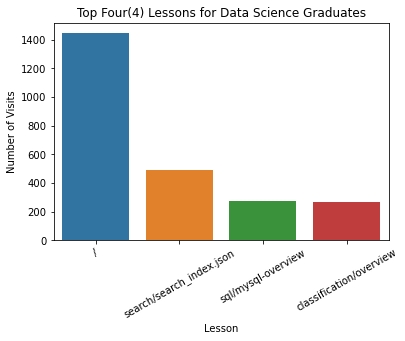

In [157]:
# Create a barplot for the top lessons for Data Science Graduates.
ax = sns.barplot(x='lesson',y='path', data=top_lessons_ds.head(4))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.ylabel('Number of Visits')
plt.xlabel('Lesson')
plt.title('Top Four(4) Lessons for Data Science Graduates')

# Takeaways
* JSON is the most visited path after graduation for Data Science students.

## Find the paths most visited after graduation for Web Development students.

In [81]:
# Create a dataframe where the curriculum hits happen after the student's graduation.
post_graduation_webdev = userlog[userlog.index > userlog.end_date]

In [82]:
# Get the value counts for top-ten paths visited.
post_graduation_webdev[post_graduation_webdev.ds_student == False].path.value_counts().head(10)

/                           14122
javascript-i                 4969
spring                       4272
search/search_index.json     3690
html-css                     3687
java-iii                     3541
java-ii                      3444
java-i                       3130
appendix                     3086
javascript-ii                2981
Name: path, dtype: int64

In [148]:
# Create a dataframe for the top lessons for Webdev graduates.
top_lessons_webdev = pd.DataFrame(post_graduation_webdev[post_graduation_webdev.ds_student == False].path.value_counts().head(10))

In [149]:
top_lessons_webdev

,path
/,14122
javascript-i,4969
spring,4272
search/search_index.json,3690
html-css,3687
java-iii,3541
java-ii,3444
java-i,3130
appendix,3086
javascript-ii,2981


In [152]:
# Reset the index and rename it to 'lesson'
top_lessons_webdev = top_lessons_webdev.reset_index().rename(columns={'index': 'lesson'})

In [153]:
top_lessons_webdev

,lesson,path
0,/,14122
1,javascript-i,4969
2,spring,4272
3,search/search_index.json,3690
4,html-css,3687
5,java-iii,3541
6,java-ii,3444
7,java-i,3130
8,appendix,3086
9,javascript-ii,2981


Text(0.5, 1.0, 'Top Four(4) Lessons for Web Development Graduates')

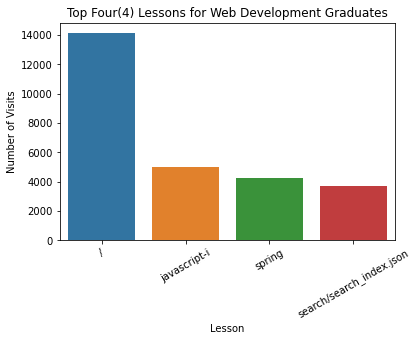

In [158]:
# Create a barplot for the top lessons for Webdev graduates.
ax = sns.barplot(x='lesson',y='path', data=top_lessons_webdev.head(4))
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
plt.ylabel('Number of Visits')
plt.xlabel('Lesson')
plt.title('Top Four(4) Lessons for Web Development Graduates')

# Takeaways
* Javascript-i and spring are the top paths for Web Development students after graduation.

In [83]:
# Get value counts of how many paths were visited for each student for each cohort.
userlog.groupby(['cohort_name','user_id']).path.count()

cohort_name  user_id
Andromeda    373          766
             374         1540
             375         1633
             376          779
             377         1160
             378          331
             379          791
             380          682
             381          857
             382          603
             383         1423
             384          993
             385          983
             386         1466
             387         1023
             388            8
             389          581
             390         1073
             391          731
             392          650
             393         1990
             394          898
             395          965
             400          744
             430         1830
             431          104
             432          105
             464          650
Apex         594          328
             595         3050
             596         1255
             597          174
             598   

## What is the total amount of hits for each student for each cohort for Web Development?

In [84]:
current_webdev_student = userlog[(userlog.index < userlog.end_date) & (userlog.ds_student == False)]

In [85]:
cohort_names

['Andromeda',
 'Apex',
 'Apollo',
 'Arches',
 'Badlands',
 'Bash',
 'Bayes',
 'Betelgeuse',
 'Ceres',
 'Curie',
 'Darden',
 'Deimos',
 'Denali',
 'Easley',
 'Europa',
 'Everglades',
 'Florence',
 'Fortuna',
 'Franklin',
 'Ganymede',
 'Glacier',
 'Hampton',
 'Hyperion',
 'Ike',
 'Joshua',
 'Jupiter',
 'Kalypso',
 'Kings',
 'Lassen',
 'Luna',
 'Mammoth',
 'Marco',
 'Neptune',
 'Niagara',
 'Oberon',
 'Olympic',
 'Pinnacles',
 'Quincy',
 'Sequoia',
 'Staff',
 'Teddy',
 'Ulysses',
 'Voyageurs',
 'Wrangell',
 'Xanadu',
 'Yosemite',
 'Zion']

In [86]:
# Get the average amount of page visits for the Andromeda cohort before graduating.
current_webdev_student[current_webdev_student.cohort_name == 'Andromeda'].groupby('user_id').path.count().mean()

782.0

In [87]:
current_webdev_student[current_webdev_student.cohort_name == 'Apollo']

,cohort_id,cohort_name,slack,start_date,end_date,created_at,updated_at,program_id,path,user_id,ip,path_split,module,lesson,program,ds_student
datetime,,,,,,,,,,,,,,,,


# Takeaways
* This dataframe is empty because no students in Apollo visited any paths before graduating. 
* This is an interesting case.

In [88]:
userlog[(userlog.index > userlog.end_date) & (userlog.cohort_name == "Apollo")]

,cohort_id,cohort_name,slack,start_date,end_date,created_at,updated_at,program_id,path,user_id,ip,path_split,module,lesson,program,ds_student
datetime,,,,,,,,,,,,,,,,
2018-03-22 19:01:49,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,/,152,207.68.209.17,"[, ]",,,Front-End,False
2018-03-22 19:01:54,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,content/html-css,152,207.68.209.17,"[content, html-css]",content,html-css,Front-End,False
2018-03-22 19:01:54,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,content/html-css/gitbook/images/favicon.ico,152,207.68.209.17,"[content, html-css, gitbook, images, favicon.ico]",content,html-css,Front-End,False
2018-03-22 19:02:47,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,content/html-css,152,207.68.209.17,"[content, html-css]",content,html-css,Front-End,False
2018-03-22 19:02:52,9,Apollo,#apollo,2015-03-30,2015-07-29,2016-06-14 19:52:26,2016-06-14 19:52:26,4,content/html-css/introduction.html,152,207.68.209.17,"[content, html-css, introduction.html]",content,html-css,Front-End,False


In [89]:
for cohort in cohort_names:
    print('\n', cohort)
    print(current_webdev_student[current_webdev_student.cohort_name == cohort].groupby('user_id').path.count().mean())


 Andromeda
782.0

 Apex
1363.857142857143

 Apollo
nan

 Arches
nan

 Badlands
nan

 Bash
744.1363636363636

 Bayes
nan

 Betelgeuse
1296.8

 Ceres
1233.3103448275863

 Curie
nan

 Darden
nan

 Deimos
991.96

 Denali
nan

 Easley
nan

 Europa
917.9285714285714

 Everglades
nan

 Florence
nan

 Fortuna
1192.75

 Franklin
nan

 Ganymede
1051.357142857143

 Glacier
nan

 Hampton
nan

 Hyperion
1239.695652173913

 Ike
nan

 Joshua
nan

 Jupiter
1104.4545454545455

 Kalypso
1030.0434782608695

 Kings
nan

 Lassen
nan

 Luna
831.15

 Mammoth
nan

 Marco
528.9354838709677

 Neptune
196.64864864864865

 Niagara
nan

 Oberon
64.3076923076923

 Olympic
nan

 Pinnacles
nan

 Quincy
nan

 Sequoia
103.71428571428571

 Staff
nan

 Teddy
815.483870967742

 Ulysses
860.2857142857143

 Voyageurs
979.9090909090909

 Wrangell
925.3461538461538

 Xanadu
1125.4

 Yosemite
713.1481481481482

 Zion
1353.68


# Takeaways
* The data in this format is a bit useless.
* I was hoping to be able to compre the average amount of hits for each cohort.

## What is the total amount of hits for each student for each cohort for Data Science?

In [90]:
current_ds_student = userlog[(userlog.index < userlog.end_date) & (userlog.ds_student == True)]

In [91]:
current_ds_student.groupby(['cohort_name','user_id']).path.count()

cohort_name  user_id
Bayes        358         876
             466        1037
             467         531
             468         675
             469        1236
             470         468
             471        1037
             472         754
             473        1167
             474         545
             475        2102
             476        1686
             477         421
             478        1230
             479        1837
             480         642
             481         996
             482        1324
             483         795
             484        1047
             485        1390
             487          17
Curie        575         480
             576        1508
             577         268
             578         759
             579        1174
             580        1193
             581        2316
             582        1124
             583         464
             584        1288
             585        1050
             586      